<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/SalaryModeling_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 24kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5962e000 @  0x7f50859fc2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 18.1MB/s 
    100% |████████████████████████████████| 2.0MB 4.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!pip install pyro-ppl

    100% |████████████████████████████████| 112kB 2.7MB/s 
  Running setup.py bdist_wheel for pyro-ppl ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/2b/07/a8/a99cd69d0221c35285eb6cfe727d2316dcd59fbcb8f7ed797e
Successfully built pyro-ppl


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
import pyro
from pyro.optim import Adam
import pandas as pd
from scipy.stats import mstats
%matplotlib inline

In [0]:
N = 200
K = 4

def get_data():
    
    a0 = 450.
    b0 = 20.
    s_a = 50.
    s_b = 5.
    s_Y = 30.

    
    a = np.random.normal(loc=a0, scale=s_a, size=(K,))
    b = np.random.normal(loc=b0, scale=s_b, size=(K,))
    
    KID = []
    X = []
    Y = []
    
    for n in range(N):
        kid = np.random.randint(0, K, 1)
        KID.append(int(kid))
        
        x = np.random.randint(22, 45, 1)
        X.append(x)
        
        Y.append(np.random.normal(loc=a[kid]+b[kid]*(x-22), scale=s_Y))

    return (np.array(X).reshape(N, 1).astype(np.float32), 
            np.array(Y).reshape(N, 1), 
            np.array(KID).reshape(N, 1).astype(np.int32))

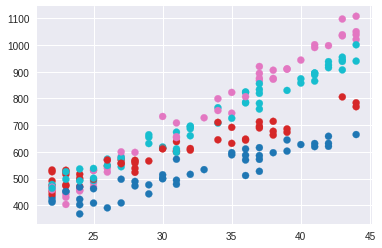

In [14]:
X_data, Y_data, KID_data = get_data()
plt.scatter(X_data, Y_data, c=KID_data, cmap='tab10')

In [0]:
df = pd.DataFrame(np.hstack([X_data, Y_data, KID_data]), 
                  columns=['age', 'salary', 'KID'])

In [16]:
df.head()

,age,salary,KID
0,32.0,660.312417,3.0
1,32.0,693.773836,3.0
2,26.0,524.619765,2.0
3,26.0,547.426754,1.0
4,22.0,473.957716,1.0


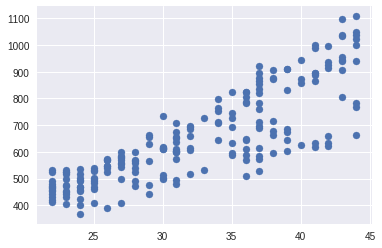

In [17]:
plt.scatter(df['age'], df['salary'])

#### モデリング
このような場合には下記のようにモデリングをしてみる。

$$
\begin{align}
n & = 1, 2, ..., N \\
z &= a + b(x - 22) \\\
y &\sim \mathcal N(z, \sigma_y^2)
\end{align}
$$

複雑に見えるかもしれないが、概ね書きように読める。

・新卒時年収 $a$ には無情報事前分布を使う。

・1年毎の昇給$b$も同様。

・合計 $N$ 人を選出している。

・$x$ 歳の基本年収 $z$は新卒年収$a$から毎年 $b$だけ上がる

・個人、年ごとの出来栄えで実際の年収 $y[n]$ は $\sigma_y^2$だけバラつく。

In [0]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        x = x - 22
        x = self.linear(x)
        return x

In [0]:
regression_model = LinearModel()

In [0]:
def model(data):
    loc, scale = torch.zeros(1, 1), 10 * torch.ones(1, 1)
    w_prior = pyro.distributions.Normal(loc, scale).independent(1)

    bias_loc, bias_scale = torch.zeros(1), 10 * torch.ones(1)
    b_prior = pyro.distributions.Normal(bias_loc, bias_scale).independent(1)

    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}

    lifted_module = pyro.random_module("module", regression_model, priors)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N):
        x_data = data[:, :-1]
        y_data = data[:, -1]

        prediction_mean = lifted_reg_model(x_data).squeeze(-1)

        pyro.sample("obs",
                    pyro.distributions.Normal(
                        prediction_mean, 0.1 * torch.ones(data.size(0))),
                    obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide(data):
    w_loc = torch.randn(1, 1)
    w_log_sig = torch.tensor(-3.0 * torch.ones(1, 1) + 0.05 * torch.randn(1, 1))
    b_loc = torch.randn(1)
    b_log_sig = torch.tensor(-3.0 * torch.ones(1) + 0.05 * torch.randn(1))

    mw_param = pyro.param("guide_mean_weight", w_loc)
    sw_param = softplus(pyro.param("guide_log_scale_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_loc)
    sb_param = softplus(pyro.param("guide_log_scale_bias", b_log_sig))
    
    w_dist = pyro.distributions.Normal(mw_param, sw_param).independent(1)
    b_dist = pyro.distributions.Normal(mb_param, sb_param).independent(1)
    dists = {'linear.weight': w_dist, 'linear.bias': b_dist}
    
    lifted_module = pyro.random_module("module", regression_model, dists)
    return lifted_module()

In [0]:
optim = pyro.optim.Adam({"lr": 0.05})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

In [78]:
pyro.clear_param_store()
data = torch.cat((torch.Tensor(X_data), torch.Tensor(Y_data)), 1)
for j in range(30000):
    loss = svi.step(data)
    if j % 3000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / float(N)))

[iteration 0001] loss: 22638889.0117
[iteration 3001] loss: 2261942.8839
[iteration 6001] loss: 1256685.4444
[iteration 9001] loss: 628705.2760
[iteration 12001] loss: 440966.7808
[iteration 15001] loss: 432425.7890
[iteration 18001] loss: 432425.4034
[iteration 21001] loss: 432425.2092
[iteration 24001] loss: 432425.1674
[iteration 27001] loss: 432425.3720


In [132]:
for name in pyro.get_param_store().get_all_param_names():
    print("[%s]: %.3f" % (name, pyro.param(name).data.numpy()))

[guide_mean_weight]: 21.127
[guide_log_scale_weight]: -7.683
[guide_mean_bias]: 434.426
[guide_log_scale_bias]: -4.808


In [0]:
X_data_pre = torch.Tensor(np.linspace(22, 60)).view(-1, 1)
y_preds = torch.zeros(len(X_data_pre), 1)
Y_preds = []
for i in range(200):
    # guide does not require the data
    sampled_reg_model = guide(None)
    Y_preds.append(sampled_reg_model(torch.Tensor(X_data_pre)))
    # run the regression model and add prediction to total
#     y_preds = y_preds + sampled_reg_model(torch.Tensor(X_data_pre))
# take the average of the predictions
Y_preds = torch.stack(Y_preds, dim=0).squeeze()
y_preds = Y_preds.mean(dim=0)

In [148]:
low_y, high_y = mstats.mquantiles(Y_preds.squeeze().detach().numpy(), 
                                  [0.025, 0.975], axis=0)

[ 434.40967743  450.79355225  467.1775032   483.56148468  499.94547852
  516.32944763  532.71344147  549.09738892  565.48127838  581.86513153
  598.24895996  614.63272583  631.01668488  647.40074127  663.78470032
  680.16867096  696.5525296   712.93618347  729.31978088  745.703573
  762.08756989  778.47150574  794.8554895   811.23932648  827.62307617
  844.00677643  860.3904071   876.77395508  893.15747681  909.54080231
  925.92412781  942.30759857  958.69116516  975.07475647  991.45837555
 1007.84162842 1024.22497864 1040.60835205 1056.99170227 1073.37505249
 1089.75835327 1106.14170349 1122.52512634 1138.90869446 1155.29218994
 1171.67578125 1188.05925354 1204.44262695 1220.82597717 1237.20935059]
[ 434.44125946  450.82560364  467.20969055  483.59391113  499.97837311
  516.36280457  532.74730133  549.13184601  565.51636597  581.90082489
  598.28534485  614.67013672  631.05489227  647.43972046  663.8245108
  680.20905701  696.59359009  712.97802429  729.36251953  745.74706421
  762.13

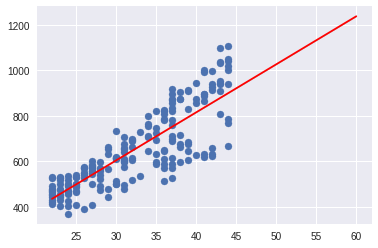

In [147]:
plt.scatter(df["age"], df["salary"])
plt.fill_between(X_data_pre.squeeze().detach().numpy(), 
                 low_y, high_y, alpha=0.5, color="gray")
plt.plot(X_data_pre.detach().numpy(), y_preds.detach().numpy(), c="r")

### NUTS


In [0]:
regression_model2 = LinearModel()

In [0]:
def model2(data):
    loc, scale = torch.zeros(1, 1), 10 * torch.ones(1, 1)
    w_prior = pyro.distributions.Normal(loc, scale).independent(1)

    bias_loc, bias_scale = torch.zeros(1), 10 * torch.ones(1)
    b_prior = pyro.distributions.Normal(bias_loc, bias_scale).independent(1)

    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}

    lifted_module = pyro.random_module("module", regression_model2, priors)
    lifted_reg_model = lifted_module()


    x_data = data[:, :-1]
    y_data = data[:, -1]

    prediction_mean = lifted_reg_model(x_data).squeeze(-1)

    pyro.sample("obs",
                pyro.distributions.Normal(
                    prediction_mean, 0.1 * torch.ones(data.size(0))),
                obs=y_data)

In [0]:
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import EmpiricalMarginal

nuts_kernel = pyro.infer.mcmc.nuts.HMC(model2, adapt_step_size=True)
mcmc_run = MCMC(nuts_kernel, 
                           num_samples=2000, 
                           warmup_steps=500).run(data)
posterior = EmpiricalMarginal(mcmc_run, 'obs')
posterior.mean


/usr/local/lib/python3.6/dist-packages/pyro/poutine/trace_struct.py:17: UserWarning: Encountered NAN log_prob_sum at site 'obs'
  warnings.warn("Encountered NAN log_prob_sum at site '{}'".format(name))
/usr/local/lib/python3.6/dist-packages/pyro/poutine/trace_struct.py:17: UserWarning: Encountered NAN log_prob_sum at site 'module$$$linear.weight'
  warnings.warn("Encountered NAN log_prob_sum at site '{}'".format(name))
/usr/local/lib/python3.6/dist-packages/pyro/poutine/trace_struct.py:17: UserWarning: Encountered NAN log_prob_sum at site 'module$$$linear.bias'
  warnings.warn("Encountered NAN log_prob_sum at site '{}'".format(name))


KeyboardInterrupt: ignored